In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Load CSV and select one ticker
df = pd.read_csv("../data/sp500_historical_clean.csv")
ticker = "AAPL"
df_t = df[df["Ticker"] == ticker].copy().sort_values("Date")

# Convert date
df_t["Date"] = pd.to_datetime(df_t["Date"])
df_t.set_index("Date", inplace=True)
df_t.head()


,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2015-10-15,AAPL,25.137804,27.965000,28.0250,27.622499,27.732500,150694000.0
2015-10-16,AAPL,24.953529,27.760000,28.0000,27.632500,27.945000,156930400.0
2015-10-19,AAPL,25.108589,27.932501,27.9375,27.527500,27.700001,119036800.0
2015-10-20,AAPL,25.567024,28.442499,28.5425,27.705000,27.834999,195871200.0
2015-10-21,AAPL,25.564787,28.440001,28.8950,28.424999,28.500000,167180800.0


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# choose features
features = ["Open", "High", "Low", "Close", "Volume"]
df_t = df[df["Ticker"] == ticker].copy().sort_values("Date")
df_t["Date"] = pd.to_datetime(df_t["Date"])
df_t.set_index("Date", inplace=True)

# compute percentage return target
df_t["Return"] = df_t["Close"].pct_change()   # (Close_t - Close_{t-1}) / Close_{t-1}
df_t.dropna(inplace=True)

data = df_t[features].values
target = df_t["Return"].values.reshape(-1, 1)

# chronological split
n = len(data)
train_end = int(n*0.7)
val_end   = int(n*0.85)


In [14]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler(feature_range=(-1, 1))  # returns can be ±

train_X = scaler_X.fit_transform(data[:train_end])
val_X   = scaler_X.transform(data[train_end:val_end])
test_X  = scaler_X.transform(data[val_end:])

train_y = scaler_y.fit_transform(target[:train_end])
val_y   = scaler_y.transform(target[train_end:val_end])
test_y  = scaler_y.transform(target[val_end:])


In [15]:
def make_sequences(X, y, lookback=60):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])  # predict return at i
    return np.array(Xs), np.array(ys)

lookback = 60
X_train, y_train = make_sequences(train_X, train_y, lookback)
X_val,   y_val   = make_sequences(val_X, val_y, lookback)
X_test,  y_test  = make_sequences(test_X, test_y, lookback)



In [16]:
# 4) PyTorch Dataset/DataLoader (same as before)
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class UniDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.tensor(self.X[i], dtype=torch.float32), torch.tensor(self.y[i], dtype=torch.float32)

train_loader = DataLoader(UniDataset(X_train,y_train), batch_size=32, shuffle=False)
val_loader   = DataLoader(UniDataset(X_val,  y_val),   batch_size=32, shuffle=False)
test_loader  = DataLoader(UniDataset(X_test, y_test),  batch_size=32, shuffle=False)



In [19]:
# 5) Vanilla LSTM (univariate)
class VanillaLSTM(nn.Module):
    def __init__(self, n_features=5, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden, layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaLSTM().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(loader):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    preds, trues = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds.append(pred.cpu().numpy())
            trues.append(y.cpu().numpy())
            total_loss += criterion(pred, y).item() * X.size(0)
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return total_loss / len(loader.dataset), preds, trues


In [21]:
best_val = float("inf")
for epoch in range(50):
    train_loss = train_one_epoch(train_loader)
    val_loss, _, _ = evaluate(val_loader)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model.pt")
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d}: Train {train_loss:.6f}, Val {val_loss:.6f}")


/home/pham156/.conda/envs/rocky9/2024.09/CS373/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pham156/.conda/envs/rocky9/2024.09/CS373/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pham156/.conda/envs/rocky9/2024.09/CS373/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([29])). This will likely lead t

Epoch 00: Train 0.023279, Val 0.010886
Epoch 05: Train 0.023274, Val 0.010605
Epoch 10: Train 0.023204, Val 0.010444
Epoch 15: Train 0.023119, Val 0.010461
Epoch 20: Train 0.023109, Val 0.010481
Epoch 25: Train 0.023099, Val 0.010449
Epoch 30: Train 0.023097, Val 0.010432
Epoch 35: Train 0.023046, Val 0.010495
Epoch 40: Train 0.023066, Val 0.010475
Epoch 45: Train 0.023073, Val 0.010501


In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
test_loss, y_pred, y_true = evaluate(test_loader)

# Invert scale
# def invert_scale(y_scaled):
#     dummy = np.zeros((len(y_scaled), len(features)))
#     dummy[:, features.index("Close")] = y_scaled
#     return scaler.inverse_transform(dummy)[:, features.index("Close")]

# inverse-scale predicted returns
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_inv = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()

# reconstruct predicted price curve
# start from last known training close
last_train_close = df_t["Close"].iloc[train_end + lookback - 1]
pred_prices = [last_train_close]
for r in y_pred_inv:
    pred_prices.append(pred_prices[-1] * (1 + r))
pred_prices = np.array(pred_prices[1:])  # drop initial

true_prices = df_t["Close"].iloc[-len(pred_prices):].values



/tmp/ipykernel_3186858/4022790368.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


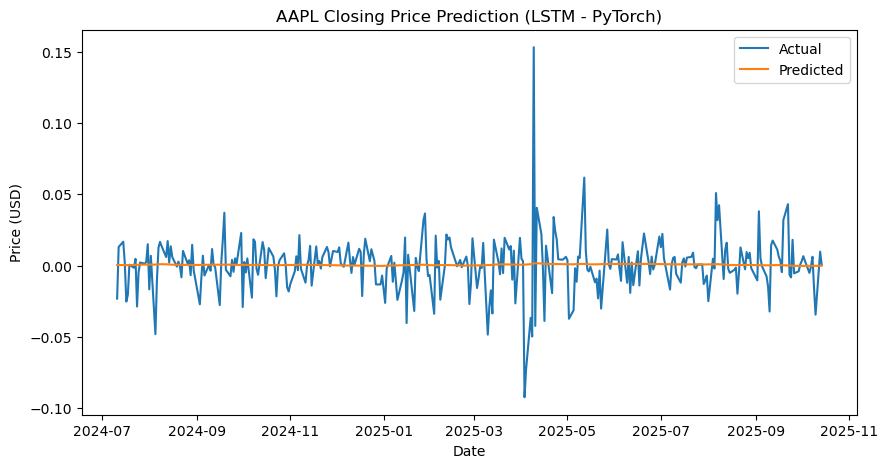

In [24]:
plt.figure(figsize=(10,5))
plt.plot(df_t.index[-len(y_true_inv):], y_true_inv, label="Actual")
plt.plot(df_t.index[-len(y_pred_inv):], y_pred_inv, label="Predicted")
plt.title(f"{ticker} Closing Price Prediction (LSTM - PyTorch)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
